In [ ]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/np.zip' -d '/content/'

Mounted at /content/drive
Archive:  /content/drive/My Drive/np.zip
  inflating: /content/np/256_192_test.npy  
  inflating: /content/np/256_192_train.npy  
  inflating: /content/np/256_192_val.npy  
  inflating: /content/np/test_labels.npy  
  inflating: /content/np/train_labels.npy  
  inflating: /content/np/val_labels.npy  


## Load In the Dataset

In [ ]:
X_train = np.load("np/256_192_train.npy")

In [ ]:
y_train = np.load("np/train_labels.npy")

In [ ]:
X_val = np.load("np/256_192_val.npy")

In [ ]:
y_val = np.load("np/val_labels.npy")

In [ ]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [ ]:
y_train.shape, y_val.shape

((8111,), (902,))

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load In the Model

In [ ]:
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [ ]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1920)


## Define the Model

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Training

### Feature Extraction

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
batch_size = 32
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
253/253 [==============================] - 194s 556ms/step - loss: 1.9949 - accuracy: 0.5515 - val_loss: 0.9834 - val_accuracy: 0.6674
Epoch 2/3
253/253 [==============================] - 163s 645ms/step - loss: 0.9607 - accuracy: 0.6842 - val_loss: 0.8289 - val_accuracy: 0.6964
Epoch 3/3
253/253 [==============================] - 131s 518ms/step - loss: 0.8739 - accuracy: 0.6995 - val_loss: 0.8051 - val_accuracy: 0.6975


### Retraining

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [ ]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
batch_size = 32
epochs = 20
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
253/253 [==============================] - 324s 1s/step - loss: 0.9259 - acc: 0.6789 - val_loss: 1.0439 - val_acc: 0.6953
Epoch 2/20
253/253 [==============================] - 291s 1s/step - loss: 0.5905 - acc: 0.7857 - val_loss: 0.6586 - val_acc: 0.7746
Epoch 3/20
253/253 [==============================] - 290s 1s/step - loss: 0.4739 - acc: 0.8286 - val_loss: 0.5360 - val_acc: 0.8058
Epoch 4/20
253/253 [==============================] - 290s 1s/step - loss: 0.4168 - acc: 0.8547 - val_loss: 0.4945 - val_acc: 0.8270
Epoch 5/20
253/253 [==============================] - 290s 1s/step - loss: 0.3608 - acc: 0.8637 - val_loss: 0.4905 - val_acc: 0.8292
Epoch 6/20
253/253 [==============================] - 289s 1s/step - loss: 0.3271 - acc: 0.8839 - val_loss: 0.6574 - val_acc: 0.8103
Epoch 7/20
253/253 [==============================] - 287s 1s/step - loss: 0.2751 - acc: 0.8982 - val_loss: 0.6090 - val_acc: 0.7879
Epoch 8/20
253/253 [==============================] - 286s 1s/step - 

In [ ]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 16s 427ms/step - loss: 0.5179 - acc: 0.8736
Validation: accuracy = 0.873614  ;  loss_v = 0.517909


## Testing

In [ ]:
X_test = np.load("np/256_192_test.npy")

In [ ]:
y_test = np.load("np/test_labels.npy")
y_test = to_categorical(y_test)

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 13s 412ms/step - loss: 0.5788 - acc: 0.8563
Test: accuracy = 0.856287  ;  loss = 0.578787


In [ ]:
model.save("DenseNetFull.h5")

Text(0.5, 1.0, 'Training and validation loss')

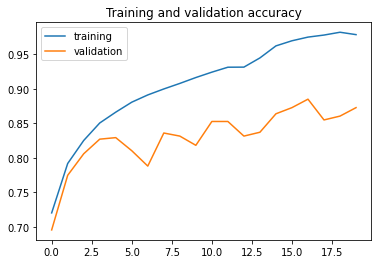

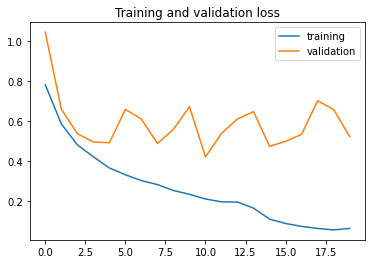

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')